<a href="https://colab.research.google.com/github/4datascience/Traffic/blob/master/Feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**INITIALISATION**

## Python Environment

### Import Python libraries

In [1]:
# Data libraries
from google.colab import drive
import os
import pandas as pd
import calendar
import numpy as np
import gc

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from seaborn import violinplot, boxenplot

# Model training
from sklearn.model_selection import cross_validate
from sklearn import metrics, preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from imblearn.ensemble import RUSBoostClassifier
from sklearn.tree import DecisionTreeClassifier
    # Keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Lambda
    # Tensorflow
import tensorflow as tf

# Statistical tests
from scipy.stats import shapiro

### SET ENVIRONMENT VARIABLES

In [2]:
# PREDICTION HORIZON
PREDICTED_MINUTES_AHEAD = 5
if (PREDICTED_MINUTES_AHEAD%5 != 0): raise ValueError("Invalid prediction horizon. Must be multiple of 5 minutes")

## Files

### Mount \<Google Drive\>

In [16]:
drive.mount('/content/drive')
!rm -rf sample_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Clone \<Github\>

In [ ]:
!sh /content/drive/MyDrive/Traffic/scripts/initialisation.sh

In [10]:
%cd /content/Traffic
!git config user.email diego@google.colab.com
!git config user.name "Google Colab"
!git config http.postBuffer 524288000

/content/Traffic


#**UPLOAD DATA**

## TO GOOGLE DRIVE [ LINK_ID, TT_ARR, LOS_DEP ]

In [ ]:


training = []
validation = []
total_size = 0

directory = '/content/drive/MyDrive/Traffic/data/processed/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df.loc[(df.index.day < 20)][['link_id', 'tt_arr']]
    training.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    # Validation set
    X = df.loc[~(df.index.day < 20)][['link_id', 'tt_arr']]
    validation.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    total_size += df.shape[0]
del df
training_df = pd.concat(training)
validation_df = pd.concat(validation)

del training, validation
print(f'Training percentage ({training_df.shape[0]} elements):\n\t{training_df.shape[0] / total_size * 100}%')
print(f'Validation percentage:\n\t{validation_df.shape[0] / total_size * 100}%')

training_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_training.csv')
validation_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_validating.csv')

Sevilla_2015.csv 365.0
Sevilla_2016.csv 366.0
Sevilla_2017.csv 365.0
Sevilla_2018.csv 273.0
Training percentage (7387200 elements):
	62.45434623813002%
Validation percentage:
	37.54261017774531%


## TO GOOGLE DRIVE [ LINK_ID, TT_ARR, TT_ARR-5, TT_ARR-10, ..., TT_ARR-N, LOS_DEP ]

In [ ]:


training = []
validation = []
total_size = 0

directory = '/content/drive/MyDrive/Traffic/data/processed/'
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df=pd.read_csv(f)
    print(f'{filename} {df.shape[0]/(60*24*6)}')
    df["date"] = pd.to_datetime(df["date"], format='%d-%b-%Y %H:%M:%S')
    df = df.set_index("date")
    Y = df.shift(-PREDICTED_MINUTES_AHEAD, freq='min')[['link_id', 'LOS_dep']]
    # Training set
    X = df.loc[(df.index.day < 20)][['link_id', 'tt_arr']]
    for offset in range(1,int((50-PREDICTED_MINUTES_AHEAD)/5)+1):
        X = pd.merge(X, df.shift(offset*5, freq='min')[['link_id', 'tt_arr']], on=['date', 'link_id'], how='inner', suffixes=[None, f'-{int(offset*5)}'])
    training.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    # Validation set
    X = df.loc[~(df.index.day < 20)][['link_id', 'tt_arr']]
    for offset in range(1,int((50-PREDICTED_MINUTES_AHEAD)/5)+1):
        X = pd.merge(X, df.shift(offset*5, freq='min')[['link_id', 'tt_arr']], on=['date', 'link_id'], how='inner', suffixes=[None, f'-{int(offset*5)}'])
    validation.append( pd.merge(X, Y, on=['date', 'link_id'], how='inner') )
    total_size += df.shape[0]
del df
training_df = pd.concat(training)
validation_df = pd.concat(validation)

del training, validation
print(f'Training percentage ({training_df.shape[0]} elements):\n\t{training_df.shape[0] / total_size * 100}%')
print(f'Validation percentage:\n\t{validation_df.shape[0] / total_size * 100}%')

training_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_temporalinfo_training.csv')
validation_df.to_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_temporalinfo_validating.csv')

Sevilla_2015.csv 365.0
Sevilla_2016.csv 366.0
Sevilla_2017.csv 365.0
Sevilla_2018.csv 273.0
Training percentage (7386120 elements):
	62.44521548575602%
Validation percentage:
	37.54463923382843%


#**DOWNLOAD DATA**

## Without temporal information

In [3]:
training_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_training.csv')
training_df["date"] = pd.to_datetime(training_df["date"], format='%Y-%m-%d %H:%M:%S')
training_df = training_df.set_index("date")
validation_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_validating.csv')
validation_df["date"] = pd.to_datetime(validation_df["date"], format='%Y-%m-%d %H:%M:%S')
validation_df = validation_df.set_index("date")

## With temporal information

In [ ]:
training_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_temporalinfo_training.csv')
training_df["date"] = pd.to_datetime(training_df["date"], format='%Y-%m-%d %H:%M:%S')
training_df = training_df.set_index("date")
validation_df = pd.read_csv(f'/content/drive/MyDrive/Traffic/data/intermediate/Sevilla_{PREDICTED_MINUTES_AHEAD}m_temporalinfo_validating.csv')
validation_df["date"] = pd.to_datetime(validation_df["date"], format='%Y-%m-%d %H:%M:%S')
validation_df = validation_df.set_index("date")

# DATA EXPLORATION

## Visual

> Dataframe content

In [ ]:
training_df[training_df['link_id']==8].head(10)

,link_id,tt_arr,tt_arr-5,tt_arr-10,tt_arr-15,tt_arr-20,tt_arr-25,tt_arr-30,tt_arr-35,tt_arr-40,tt_arr-45,LOS_dep
date,,,,,,,,,,,,
2015-01-01 00:45:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:46:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:47:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:48:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:49:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:50:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:51:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:52:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1
2015-01-01 00:53:00,8,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,109.0,1


In [ ]:
training_df[training_df['link_id']==5].sample(n=10)

,link_id,tt_arr,tt_arr-5,tt_arr-10,tt_arr-15,tt_arr-20,tt_arr-25,tt_arr-30,tt_arr-35,tt_arr-40,tt_arr-45,LOS_dep
date,,,,,,,,,,,,
2018-02-12 04:15:00,5,310.0,310.0,310.0,310.0,310.0,310.0,310.0,310.0,310.0,310.0,1
2018-08-01 23:42:00,5,297.0,296.0,296.0,296.0,296.0,296.0,296.0,296.0,294.5,294.5,1
2018-02-04 07:47:00,5,304.0,304.0,304.0,274.0,274.0,274.0,274.0,274.0,274.0,274.0,1
2015-11-05 11:15:00,5,324.0,324.0,337.5,337.5,320.0,320.0,310.5,310.5,324.0,324.0,1
2015-10-12 19:19:00,5,315.0,315.0,315.0,315.0,325.0,325.0,325.0,308.0,308.0,319.0,1
2015-09-07 06:14:00,5,310.0,299.0,299.0,299.0,299.0,299.0,299.0,300.0,300.0,300.0,1
2016-04-05 11:07:00,5,353.5,317.0,330.0,330.0,368.0,368.0,348.0,348.0,348.0,348.0,1
2016-03-06 17:39:00,5,299.0,296.0,296.0,296.0,311.0,311.0,311.0,311.0,311.0,311.0,1
2016-02-15 07:42:00,5,416.5,392.0,394.0,410.5,410.5,349.0,349.0,331.5,331.5,297.0,4


> Per weekday link LOS histogram


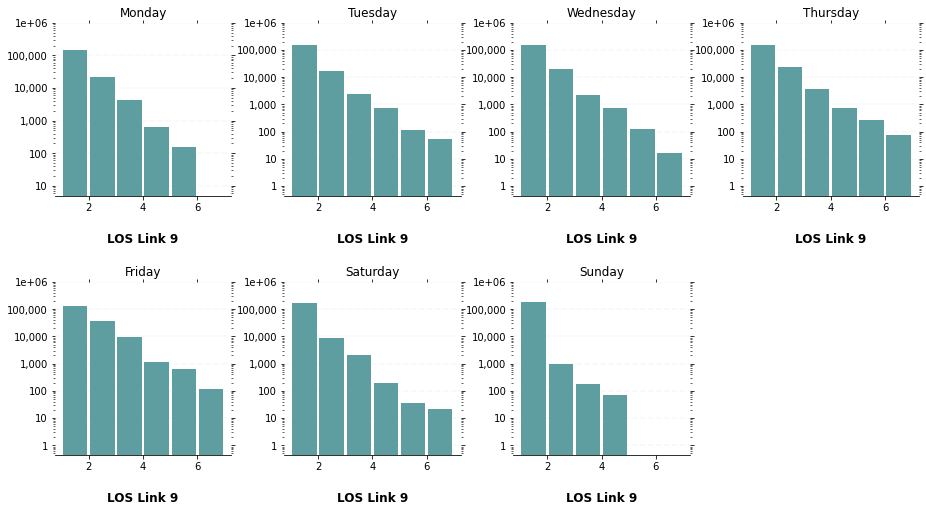

In [ ]:
LINK = 9
base_df=training_df[training_df['link_id']==LINK]
plot_df = pd.merge(base_df['LOS_dep'],
pd.DataFrame(list(base_df.index.weekday), index=base_df.index, columns=['weekday']), left_index=True, right_index=True)

# Plot histogram LOS per weekday
ax = plot_df.hist(column='LOS_dep', by=plot_df['weekday'], bins=6, range=(1,7), log=True, grid=False, layout=(2,4), figsize=(15,8), color='#5F9EA0', zorder=2, rwidth=0.9)

for x_col in ax:
    for x in x_col:
        if x.get_title() != '':
            # Despine
            x.spines['right'].set_visible(False)
            x.spines['top'].set_visible(False)
            x.spines['left'].set_visible(False)

            # Switch off ticks
            x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

            # Draw horizontal axis lines
            vals = x.get_yticks()
            for tick in vals:
                x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

            # Set y-lim
            x.set_ylim(top=1e6)

            # Set x-axis label
            x.set_xlabel(f"LOS Link {LINK}", labelpad=20, weight='bold', size=12)

            # Format y-axis label
            x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

            # Set title
            x.set_title(calendar.day_name[int(x.get_title())])

            x.tick_params(axis='x', rotation=0)

> Per hour link LOS histogram

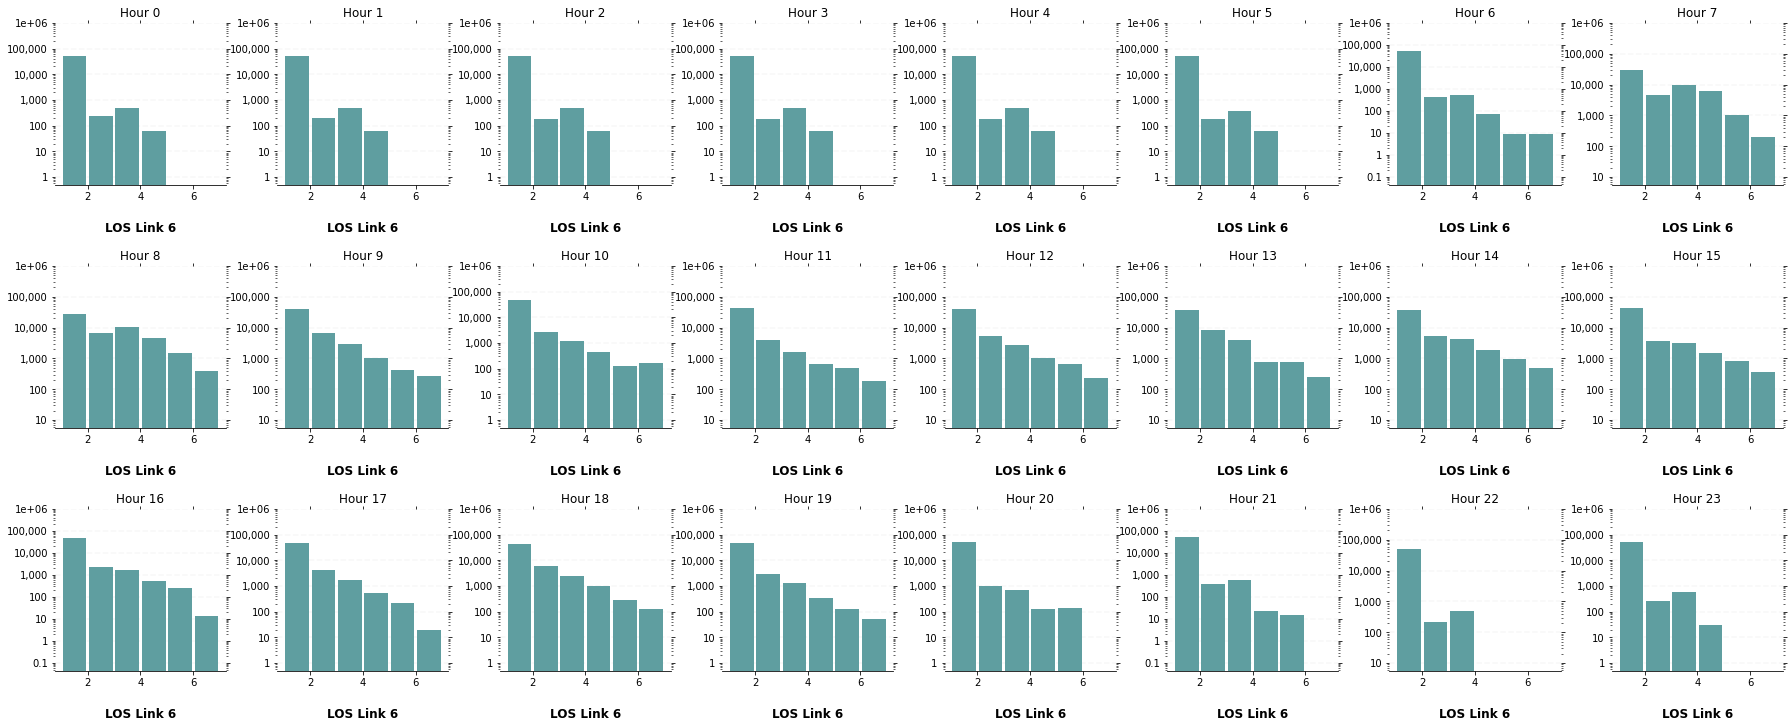

In [ ]:
LINK = 6
base_df=training_df[training_df['link_id']==LINK]
plot_df = pd.merge(base_df['LOS_dep'],
pd.DataFrame(list(base_df.index.hour), index=base_df.index, columns=['hour']), left_index=True, right_index=True)

# Plot histogram LOS per hour
ax = plot_df.hist(column='LOS_dep', by=plot_df['hour'], bins=6, range=(1,7), log=True, grid=False, layout=(3,8), figsize=(30,12), color='#5F9EA0', zorder=2, rwidth=0.9)

for x_col in ax:
    for x in x_col:
        if x.get_title() != '':
            # Despine
            x.spines['right'].set_visible(False)
            x.spines['top'].set_visible(False)
            x.spines['left'].set_visible(False)

            # Switch off ticks
            x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

            # Draw horizontal axis lines
            vals = x.get_yticks()
            for tick in vals:
                x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

            # Set y-lim
            x.set_ylim(top=1e6)

            # Set x-axis label
            x.set_xlabel(f"LOS Link {LINK}", labelpad=20, weight='bold', size=12)

            # Format y-axis label
            x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

            # Set title
            x.set_title(f'Hour {int(x.get_title())}')

            x.tick_params(axis='x', rotation=0)

> Statistical distribution of Times of Arrival per Level of Service

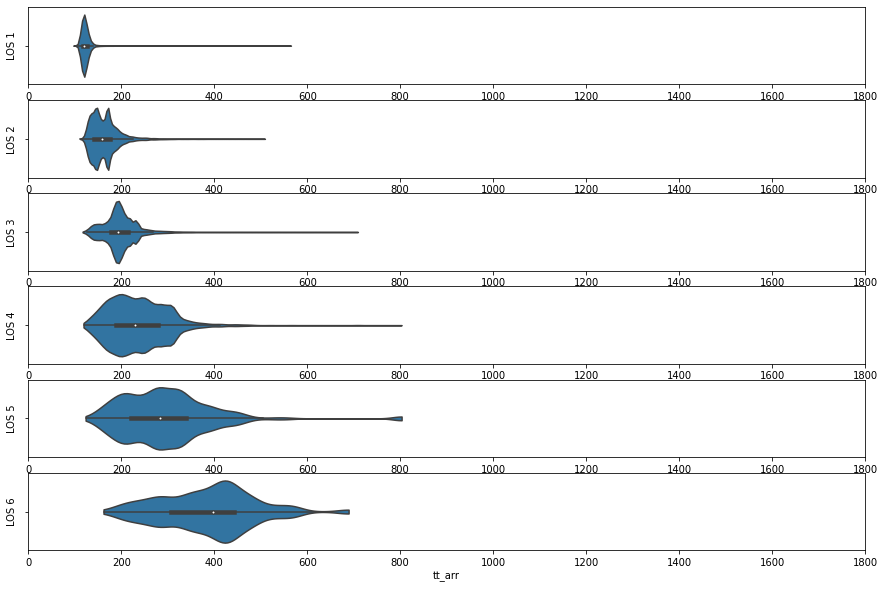

In [ ]:
LINK = 7
plot_df=training_df[(training_df['link_id']==LINK)]

# Plot violinplot tt_arr per LOS
fig, axs = plt.subplots(6,1)
fig.set_size_inches(15, 10)
for LOS in range(1,7):
    axs[LOS-1].set(xlim=(0, 1800))
    violinplot(data=plot_df[plot_df["LOS_dep"] == LOS], x="tt_arr", cut=0, ax=axs[LOS-1]).set(ylabel=f"LOS {LOS}")

## Statistical

> Features available

In [ ]:
training_df[['link_id','tt_arr','LOS_dep']].describe()

,link_id,tt_arr,LOS_dep
count,7.386120e+06,7.386120e+06,7.386120e+06
mean,7.500000e+00,2.466202e+02,1.214961e+00
std,1.707825e+00,1.247695e+02,6.847303e-01
min,5.000000e+00,9.400000e+01,1.000000e+00
25%,6.000000e+00,1.250000e+02,1.000000e+00
50%,7.500000e+00,2.440000e+02,1.000000e+00
75%,9.000000e+00,3.080000e+02,1.000000e+00
max,1.000000e+01,1.756500e+03,6.000000e+00


> Per-link id data balance





In [ ]:
training_df[training_df['LOS_dep']==4]['link_id'].value_counts()[training_df.link_id.unique()]

5     28407
6     20875
7     11497
8      8188
9      4173
10    20101
Name: link_id, dtype: int64

> Test normality of Times of Arrival

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    for LOS in range(1,7):
        print(f"\tLOS {LOS}\tPvalue {shapiro(training_df[(training_df['link_id']==LINK) & (training_df['LOS_dep']==LOS)]['tt_arr']).pvalue}")

LINK 5
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 3.0895828541433567e-41
	LOS 6	Pvalue 5.011837864629182e-29
LINK 6
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 8.23121877165319e-39
	LOS 6	Pvalue 1.0535939090175312e-16
LINK 7
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 0.0
	LOS 6	Pvalue 6.297267937140083e-13
LINK 8
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 2.802596928649634e-45
	LOS 5	Pvalue 5.859512404482781e-33
	LOS 6	Pvalue 2.4114945272565777e-41
LINK 9
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 1.3216130666316006e-38
	LOS 5	Pvalue 3.42259417150919e-14
	LOS 6	Pvalue 7.32835389594122e-11
LINK 10
	LOS 1	Pvalue 0.0
	LOS 2	Pvalue 0.0
	LOS 3	Pvalue 0.0
	LOS 4	Pvalue 0.0
	LOS 5	Pvalue 1.401298464324817e-45
	LOS 6	Pvalue 1.0998466610191978e-22


# **NAIVE BAYES**

## **NO FEATURE ENGINEERING**

### *Training*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    X = training_df[training_df['link_id'] == LINK]['tt_arr'].values.reshape(-1, 1)
    y = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
    clf = make_pipeline(preprocessing.StandardScaler(), GaussianNB())

    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(clf, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        score = results[f'test_recall{LOS}']
        print(f"\tLOS {LOS}: Recall {round(sum(score)/CV*100, 2)}%")

LINK 5
	LOS 1: Recall 97.14%
	LOS 2: Recall 33.86%
	LOS 3: Recall 33.81%
	LOS 4: Recall 18.52%
	LOS 5: Recall 24.02%
	LOS 6: Recall 53.54%
LINK 6
	LOS 1: Recall 98.17%
	LOS 2: Recall 34.94%
	LOS 3: Recall 43.02%
	LOS 4: Recall 14.94%
	LOS 5: Recall 22.74%
	LOS 6: Recall 36.91%
LINK 7
	LOS 1: Recall 98.38%
	LOS 2: Recall 44.38%
	LOS 3: Recall 49.92%
	LOS 4: Recall 18.41%
	LOS 5: Recall 15.15%
	LOS 6: Recall 21.02%
LINK 8
	LOS 1: Recall 99.56%
	LOS 2: Recall 34.07%
	LOS 3: Recall 67.94%
	LOS 4: Recall 8.66%
	LOS 5: Recall 14.35%
	LOS 6: Recall 64.07%
LINK 9
	LOS 1: Recall 97.85%
	LOS 2: Recall 72.8%
	LOS 3: Recall 26.59%
	LOS 4: Recall 28.52%
	LOS 5: Recall 12.67%
	LOS 6: Recall 10.0%
LINK 10
	LOS 1: Recall 99.12%
	LOS 2: Recall 43.34%
	LOS 3: Recall 35.32%
	LOS 4: Recall 32.7%
	LOS 5: Recall 45.56%
	LOS 6: Recall 45.13%


### *Validation*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    X_train = training_df[training_df['link_id'] == LINK]['tt_arr'].values.reshape(-1, 1)
    y_train = training_df[training_df['link_id'] == LINK]['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        X_test = sc.transform( validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)]['tt_arr'].values.reshape(-1, 1) )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 97.23%
	LOS 2: Recall 53.06%
	LOS 3: Recall 40.82%
	LOS 4: Recall 21.36%
	LOS 5: Recall 22.88%
	LOS 6: Recall 59.9%
LINK 6
	LOS 1: Recall 96.11%
	LOS 2: Recall 34.04%
	LOS 3: Recall 33.21%
	LOS 4: Recall 15.45%
	LOS 5: Recall 17.77%
	LOS 6: Recall 34.31%
LINK 7
	LOS 1: Recall 98.42%
	LOS 2: Recall 57.11%
	LOS 3: Recall 46.48%
	LOS 4: Recall 13.87%
	LOS 5: Recall 16.24%
	LOS 6: Recall 30.1%
LINK 8
	LOS 1: Recall 99.53%
	LOS 2: Recall 37.57%
	LOS 3: Recall 80.84%
	LOS 4: Recall 8.35%
	LOS 5: Recall 8.25%
	LOS 6: Recall 60.68%
LINK 9
	LOS 1: Recall 97.78%
	LOS 2: Recall 74.72%
	LOS 3: Recall 27.35%
	LOS 4: Recall 37.26%
	LOS 5: Recall 12.93%
	LOS 6: Recall 28.05%
LINK 10
	LOS 1: Recall 99.24%
	LOS 2: Recall 46.15%
	LOS 3: Recall 33.92%
	LOS 4: Recall 33.91%
	LOS 5: Recall 46.21%
	LOS 6: Recall 46.8%


## **FEATURE ENGINEERING ADJACENT LINK INFORMATION**

### *Features creation*

For each link, the tt_arrival of the other links are added as features. Therefore we will be using 6 features in total.

### *Training*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link]['tt_arr'], on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X = training_df_link.filter(regex=("tt_ar[^-]+$")).values
    y = training_df_link['LOS_dep'].values
    clf = make_pipeline(preprocessing.StandardScaler(), GaussianNB())

    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(clf, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        score = results[f'test_recall{LOS}']
        print(f"\tLOS {LOS}: Recall {round(sum(score)/CV*100, 2)}%")

LINK 5
	LOS 1: Recall 94.51%
	LOS 2: Recall 41.46%
	LOS 3: Recall 28.26%
	LOS 4: Recall 16.86%
	LOS 5: Recall 19.81%
	LOS 6: Recall 51.36%
LINK 6
	LOS 1: Recall 94.15%
	LOS 2: Recall 39.69%
	LOS 3: Recall 37.99%
	LOS 4: Recall 16.5%
	LOS 5: Recall 25.83%
	LOS 6: Recall 40.06%
LINK 7
	LOS 1: Recall 93.53%
	LOS 2: Recall 54.94%
	LOS 3: Recall 40.01%
	LOS 4: Recall 16.91%
	LOS 5: Recall 13.15%
	LOS 6: Recall 46.87%
LINK 8
	LOS 1: Recall 94.87%
	LOS 2: Recall 56.78%
	LOS 3: Recall 55.73%
	LOS 4: Recall 23.22%
	LOS 5: Recall 10.85%
	LOS 6: Recall 63.36%
LINK 9
	LOS 1: Recall 92.85%
	LOS 2: Recall 64.31%
	LOS 3: Recall 32.22%
	LOS 4: Recall 30.34%
	LOS 5: Recall 26.8%
	LOS 6: Recall 32.07%
LINK 10
	LOS 1: Recall 94.22%
	LOS 2: Recall 46.35%
	LOS 3: Recall 29.58%
	LOS 4: Recall 22.92%
	LOS 5: Recall 35.38%
	LOS 6: Recall 46.8%


### *Validation*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df[training_df['link_id'] == LINK].copy()

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link]['tt_arr'], on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X_train = training_df_link.filter(regex=("tt_ar[^-]+$")).values
    y_train = training_df_link['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link]['tt_arr'], on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = sc.transform( validation_df_link.filter(regex=("tt_ar[^-]+$")).values )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 94.71%
	LOS 2: Recall 45.1%
	LOS 3: Recall 38.25%
	LOS 4: Recall 20.15%
	LOS 5: Recall 24.19%
	LOS 6: Recall 59.22%
LINK 6
	LOS 1: Recall 92.41%
	LOS 2: Recall 38.44%
	LOS 3: Recall 46.79%
	LOS 4: Recall 17.23%
	LOS 5: Recall 26.79%
	LOS 6: Recall 35.65%
LINK 7
	LOS 1: Recall 92.15%
	LOS 2: Recall 61.94%
	LOS 3: Recall 42.9%
	LOS 4: Recall 14.3%
	LOS 5: Recall 12.48%
	LOS 6: Recall 47.77%
LINK 8
	LOS 1: Recall 94.01%
	LOS 2: Recall 60.07%
	LOS 3: Recall 76.98%
	LOS 4: Recall 19.58%
	LOS 5: Recall 10.38%
	LOS 6: Recall 62.61%
LINK 9
	LOS 1: Recall 91.33%
	LOS 2: Recall 66.3%
	LOS 3: Recall 34.29%
	LOS 4: Recall 35.3%
	LOS 5: Recall 24.19%
	LOS 6: Recall 31.44%
LINK 10
	LOS 1: Recall 92.21%
	LOS 2: Recall 52.36%
	LOS 3: Recall 29.03%
	LOS 4: Recall 25.99%
	LOS 5: Recall 37.58%
	LOS 6: Recall 49.08%


## **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

### *Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

### *Training*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X = training_df_link.filter(regex=("tt_arr.*")).values
    y = training_df_link['LOS_dep'].values
    clf = make_pipeline(preprocessing.StandardScaler(), GaussianNB())

    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(clf, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        score = results[f'test_recall{LOS}']
        print(f"\tLOS {LOS}: Recall {round(sum(score)/CV*100, 2)}%")

LINK 5
	LOS 1: Recall 92.07%
	LOS 2: Recall 34.89%
	LOS 3: Recall 18.13%
	LOS 4: Recall 15.49%
	LOS 5: Recall 19.2%
	LOS 6: Recall 52.36%
LINK 6
	LOS 1: Recall 91.12%
	LOS 2: Recall 32.68%
	LOS 3: Recall 27.95%
	LOS 4: Recall 14.78%
	LOS 5: Recall 20.35%
	LOS 6: Recall 51.26%
LINK 7
	LOS 1: Recall 90.29%
	LOS 2: Recall 49.96%
	LOS 3: Recall 25.85%
	LOS 4: Recall 21.68%
	LOS 5: Recall 12.16%
	LOS 6: Recall 46.51%
LINK 8
	LOS 1: Recall 91.97%
	LOS 2: Recall 33.39%
	LOS 3: Recall 40.8%
	LOS 4: Recall 35.77%
	LOS 5: Recall 10.35%
	LOS 6: Recall 53.98%
LINK 9
	LOS 1: Recall 90.15%
	LOS 2: Recall 50.72%
	LOS 3: Recall 15.86%
	LOS 4: Recall 7.43%
	LOS 5: Recall 30.02%
	LOS 6: Recall 61.03%
LINK 10
	LOS 1: Recall 90.99%
	LOS 2: Recall 38.34%
	LOS 3: Recall 15.67%
	LOS 4: Recall 17.91%
	LOS 5: Recall 19.61%
	LOS 6: Recall 46.31%


### *Validation*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df[training_df['link_id'] == LINK].copy()

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X_train = training_df_link.filter(regex=("tt_arr.*")).values
    y_train = training_df_link['LOS_dep'].values
    
    sc = preprocessing.StandardScaler()
    X_train = sc.fit_transform(X_train)

    model = GaussianNB().fit(X_train, y_train)
    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = sc.transform( validation_df_link.filter(regex=("tt_arr.*")).values )
        y_pred = model.predict(X_test)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

LINK 5
	LOS 1: Recall 92.13%
	LOS 2: Recall 39.55%
	LOS 3: Recall 29.16%
	LOS 4: Recall 19.54%
	LOS 5: Recall 23.77%
	LOS 6: Recall 62.57%
LINK 6
	LOS 1: Recall 89.42%
	LOS 2: Recall 33.89%
	LOS 3: Recall 39.04%
	LOS 4: Recall 15.23%
	LOS 5: Recall 22.03%
	LOS 6: Recall 41.77%
LINK 7
	LOS 1: Recall 88.72%
	LOS 2: Recall 58.36%
	LOS 3: Recall 28.98%
	LOS 4: Recall 20.79%
	LOS 5: Recall 11.4%
	LOS 6: Recall 37.96%
LINK 8
	LOS 1: Recall 89.82%
	LOS 2: Recall 32.24%
	LOS 3: Recall 68.63%
	LOS 4: Recall 34.23%
	LOS 5: Recall 15.5%
	LOS 6: Recall 48.55%
LINK 9
	LOS 1: Recall 87.66%
	LOS 2: Recall 53.49%
	LOS 3: Recall 17.93%
	LOS 4: Recall 3.58%
	LOS 5: Recall 16.82%
	LOS 6: Recall 47.88%
LINK 10
	LOS 1: Recall 87.75%
	LOS 2: Recall 33.32%
	LOS 3: Recall 17.89%
	LOS 4: Recall 17.53%
	LOS 5: Recall 19.25%
	LOS 6: Recall 48.41%


# **RUSBoost**

## **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

### *Features creation*

For each link, the tt_arrival of the other links, covering the previous 50min from prediction time, are added as features. Therefore we will be using 60 features in total as maximum.

### *Training*

In [ ]:
for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link].filter(regex=("tt_arr.*")), on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X = training_df_link.filter(regex=("tt_arr.*")).values
    y = training_df_link['LOS_dep'].values
    clf = RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=128), n_estimators=60, learning_rate=0.3)

    # 5-fold cross validation
    CV = 5
    scoring = {'recall1': metrics.make_scorer(metrics.recall_score, average = None, labels = [1]), 
        'recall2': metrics.make_scorer(metrics.recall_score, average = None, labels = [2]),
        'recall3': metrics.make_scorer(metrics.recall_score, average = None, labels = [3]),
        'recall4': metrics.make_scorer(metrics.recall_score, average = None, labels = [4]), 
        'recall5': metrics.make_scorer(metrics.recall_score, average = None, labels = [5]),
        'recall6': metrics.make_scorer(metrics.recall_score, average = None, labels = [6])}
    results = cross_validate(clf, X, y, cv=CV, scoring=scoring, return_train_score = False)
    for LOS in range(1,7):
        score = results[f'test_recall{LOS}']
        print(f"\tLOS {LOS}: Recall {round(sum(score)/CV*100, 2)}%")

LINK 5
	LOS 1: Recall 92.22%
	LOS 2: Recall 40.94%
	LOS 3: Recall 36.4%
	LOS 4: Recall 11.25%
	LOS 5: Recall 5.47%
	LOS 6: Recall 23.26%
LINK 6
	LOS 1: Recall 91.73%
	LOS 2: Recall 41.74%
	LOS 3: Recall 43.6%
	LOS 4: Recall 23.72%
	LOS 5: Recall 8.57%
	LOS 6: Recall 2.72%
LINK 7
	LOS 1: Recall 89.84%
	LOS 2: Recall 40.22%
	LOS 3: Recall 53.07%
	LOS 4: Recall 12.77%
	LOS 5: Recall 2.0%
	LOS 6: Recall 0.74%
LINK 8
	LOS 1: Recall 98.97%
	LOS 2: Recall 26.1%
	LOS 3: Recall 44.81%
	LOS 4: Recall 3.87%
	LOS 5: Recall 2.66%
	LOS 6: Recall 27.67%
LINK 9
	LOS 1: Recall 84.57%
	LOS 2: Recall 65.38%
	LOS 3: Recall 55.9%
	LOS 4: Recall 23.82%
	LOS 5: Recall 7.91%
	LOS 6: Recall 3.45%
LINK 10
	LOS 1: Recall 98.26%
	LOS 2: Recall 23.83%
	LOS 3: Recall 16.58%
	LOS 4: Recall 17.16%
	LOS 5: Recall 22.2%
	LOS 6: Recall 21.11%


# **LSTM**

## **FEATURE ENGINEERING ADJACENT LINK INFORMATION + TEMPORAL INFORMATION (UP TO PREVIOUS 45MIN)**

**TRAIN or LOAD switch**

In [27]:
train_again = False

### *Training*

In [28]:
# pick a window size of previous 45 minutes
sequence_length = (50-PREDICTED_MINUTES_AHEAD)

# function to reshape features into (samples, time steps, features) 
def gen_sequence(data_array, seq_length):
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# function to generate labels
def gen_labels(data_array, seq_length):
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements]


for LINK in range(5,11):
    print(f"LINK {LINK}")
    other_links = [5,6,7,8,9,10]; other_links.remove(LINK)
    training_df_link = training_df.copy()
    training_df_link = training_df_link[training_df_link['link_id'] == LINK]

    for other_link in other_links:
        training_df_link = pd.merge(training_df_link, training_df[training_df['link_id'] == other_link]['tt_arr'], on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
    
    X = training_df_link.filter(regex=("tt_ar[^-]+$")).values
    # Min-Max Scaling
    sc = preprocessing.MinMaxScaler()
    X = sc.fit_transform(X)

    if train_again:
        X = gen_sequence(X, sequence_length)
        X = np.stack(list(X), axis=0)
        print(f'Size of training data array {X.shape}')
        y = gen_labels(training_df_link['LOS_dep'].values, sequence_length)
        y = np.expand_dims(y, axis=1)
        
        onehot_encoder = preprocessing.OneHotEncoder()
        y = onehot_encoder.fit_transform(y).toarray()
        print(f'Size of training labels {y.shape}')

        # build the model
        num_features = X.shape[2]
        num_out = y.shape[1]

        model = keras.models.Sequential()

        model.add(keras.layers.LSTM(
                input_shape=(sequence_length, num_features),
                units=100,
                return_sequences=True))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.LSTM(
                units=50,
                return_sequences=False))
        model.add(keras.layers.Dropout(0.2))

        model.add(keras.layers.Dense(units=6, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        model.fit(X, y, epochs=10, batch_size=500, validation_split=0.005, verbose=1)

        model.save(f'/content/Traffic/models/LSTM_link{LINK}_predminutes{PREDICTED_MINUTES_AHEAD}.h5')
    
    else:
        model = keras.models.load_model(f'/content/Traffic/models/LSTM_link{LINK}_predminutes{PREDICTED_MINUTES_AHEAD}.h5')
    
    for LOS in range(1,7):
        validation_df_link = validation_df[(validation_df['link_id'] == LINK) & (validation_df['LOS_dep'] == LOS)].copy()
        for other_link in other_links:
            validation_df_link = pd.merge(validation_df_link, validation_df[validation_df['link_id'] == other_link]['tt_arr'], on=['date'], how='inner', suffixes=[None, f'_{other_link}'])
        X_test = sc.transform( validation_df_link.filter(regex=("tt_ar[^-]+$")).values )
        X_test = gen_sequence(X_test, sequence_length)
        X_test = np.stack(list(X_test), axis=0).astype(np.float32)
        y_pred = model.predict(X_test)
        y_pred = onehot_encoder.inverse_transform(y_pred)

        score = metrics.recall_score([LOS]*len(y_pred), y_pred, average='micro')
        print(f"\tLOS {LOS}: Recall {round(score*100, 2) }%")

    del model
    gc.collect()

LINK 5
17716/17716 [==============================] - 69s 4ms/step
	LOS 1: Recall 96.25%
2563/2563 [==============================] - 10s 4ms/step
	LOS 2: Recall 38.85%
1645/1645 [==============================] - 7s 4ms/step
	LOS 3: Recall 39.37%
634/634 [==============================] - 2s 4ms/step
	LOS 4: Recall 19.88%
321/321 [==============================] - 2s 5ms/step
	LOS 5: Recall 19.66%
245/245 [==============================] - 1s 4ms/step
	LOS 6: Recall 42.19%
LINK 6
19745/19745 [==============================] - 76s 4ms/step
	LOS 1: Recall 97.88%
1298/1298 [==============================] - 5s 4ms/step
	LOS 2: Recall 27.68%
1464/1464 [==============================] - 6s 4ms/step
	LOS 3: Recall 62.14%
424/424 [==============================] - 2s 4ms/step
	LOS 4: Recall 20.06%
141/141 [==============================] - 1s 4ms/step
	LOS 5: Recall 25.43%
53/53 [==============================] - 0s 4ms/step
	LOS 6: Recall 16.84%
LINK 7
19653/19653 [=========================

# **CLEAN UP**

In [ ]:
!git status

In [ ]:
!git pull

## COMMIT AND REMOVE

In [29]:
%cd /content/Traffic
!sh /content/drive/MyDrive/Traffic/scripts/logout.sh
drive.flush_and_unmount()

/content/Traffic
: not found
fatal: pathspec '.?' did not match any files
On branch master
Your branch is ahead of 'origin/master' by 1 commit.
  (use "git push" to publish your local commits)

nothing to commit, working tree clean
Everything up-to-date


In [30]:
!rm -rf /content/Traffic